# Metadata processing
A notebook to process the metadata of the Bern cohort WSIs

## Import libraries and load data

In [83]:
import Abed_utils

import os
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter, KaplanMeierFitter
from sklearn.preprocessing import LabelEncoder

In [62]:
df = pd.read_pickle('./metadata/bern_data.pkl')
df.head()

,patient_id,gender,age,diagnosis,location_specific,location,pt,pt_group,pn,pn_group,...,tsr_path,tsr_cls_path,tsr_q25,tsr_q50,tsr_q75,tsr_mean,tsr_est_q25,tsr_est_q50,tsr_est_q75,tsr_est_mean
0,3,female,82.991781,adenocarcinoma,recto,rectum,pt2,pt012,pn0,pn0,...,/mnt/data/dataset/bern_cohort_clean/3/output/s...,/mnt/data/dataset/bern_cohort_clean/3/output/s...,0.936087,0.976751,0.990994,0.955028,0.824026,0.876453,0.924482,0.872773
1,3,female,82.991781,adenocarcinoma,recto,rectum,pt2,pt012,pn0,pn0,...,/mnt/data/dataset/bern_cohort_clean/3/output/s...,/mnt/data/dataset/bern_cohort_clean/3/output/s...,0.940220,0.971893,0.986070,0.930820,0.771250,0.823717,0.877430,0.820560
4,6,female,87.367123,adenocarcinoma,descending,left,pt3,pt34,pn1,pn12,...,/mnt/data/dataset/bern_cohort_clean/6/output/s...,/mnt/data/dataset/bern_cohort_clean/6/output/s...,0.022578,0.054593,0.540306,0.279577,0.394779,0.487238,0.608896,0.509430
5,6,female,87.367123,adenocarcinoma,descending,left,pt3,pt34,pn1,pn12,...,/mnt/data/dataset/bern_cohort_clean/6/output/s...,/mnt/data/dataset/bern_cohort_clean/6/output/s...,0.063587,0.150189,0.607203,0.332216,0.457595,0.509831,0.598535,0.512643
6,6,female,87.367123,adenocarcinoma,descending,left,pt3,pt34,pn1,pn12,...,/mnt/data/dataset/bern_cohort_clean/6/output/s...,/mnt/data/dataset/bern_cohort_clean/6/output/s...,0.017364,0.042972,0.115521,0.130877,0.419876,0.474648,0.515490,0.466747


In [94]:
# Add tsr
pred_path = os.path.join(Abed_utils.OUTPUT_ROOT, 'predictions_KNN')
calculated_files = [x.split('_seg')[0] for x in os.listdir(pred_path)]

def calculate_tsr(filename, accepted_files=calculated_files, pred_path=pred_path, default_value=np.nan):
    if filename in accepted_files:
        d = np.load(os.path.join(pred_path, f'{filename}_seg_dino_imagenet_100ep_KNN.npy'), allow_pickle=True).item()
        preds = d['classification']
        lbls = d['classification_labels']
        T = preds[preds == lbls.index('TUM')].sum()
        S = preds[preds == lbls.index('STR')].sum()
        return T/(T+S)
    else:
        return default_value

df['tsr'] = df.slide_filename.map(calculate_tsr)
df[['slide_filename', 'tsr']].dropna().head()
# for wsi in glob(os.path.join(pred_path, '*.npy')):
#     print(np.load(wsi, allow_pickle=True).item())
#     print(os.path.basename(wsi).split('_seg')[0])
#     if os.path.basename(wsi).split('_seg')[0] in df['slide_filename']:
#         d = np.load(wsi, allow_pickle=True).item()
#         preds = d['classification']
#         lbls = d['classification_labels']
#         tsr = preds[preds == lbls.index('TUM')].sum()/preds[preds == lbls.index('STR')].sum()
#         idx = df['slide_filename'].in



,slide_filename,tsr
0,003b_B2010.14359_I-D_HE.mrxs,0.784009
1,003c_B2010.14359_I-E_HE.mrxs,0.728927
9,010b_B2010.34423_D_HE.mrxs,0.561417
10,010c_B2010.34423_F_HE.mrxs,0.614250
11,010d_B2010.34423_G_HE.mrxs,0.558369


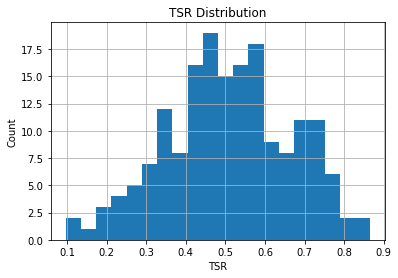

In [95]:
df.tsr.hist(bins=20)
plt.title('TSR Distribution')
plt.xlabel('TSR')
plt.ylabel('Count')
plt.show()

In [96]:
feature_cols = ['pm', 'pn', 'pt', 'tnm', 'tbc', 'tsr']
target_cols = ['os', 'os_event']

data = df[feature_cols + target_cols].dropna()
encoders = {}
for col in data:
    if isinstance(data[col].dtype, pd.CategoricalDtype):
        encoders[col] = LabelEncoder().fit(data[col])
        data[col] = encoders[col].transform(data[col])

model = CoxPHFitter()
model.fit(data, duration_col=target_cols[0], event_col=target_cols[1], show_progress=True)

model.print_summary()

Iteration 1: norm_delta = 0.49652, step_size = 0.9000, log_lik = -265.43078, newton_decrement = 4.21456, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.09012, step_size = 0.9000, log_lik = -262.10591, newton_decrement = 0.25990, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.01567, step_size = 0.9000, log_lik = -261.83925, newton_decrement = 0.00789, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00027, step_size = 1.0000, log_lik = -261.83127, newton_decrement = 0.00000, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -261.83127, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 5 iterations.


C:\Users\Zace VR\anaconda3\envs\fresh\lib\site-packages\lifelines\utils\printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 150 total observations, 90 right-censored observations>
             duration col = 'os'
                event col = 'os_event'
      baseline estimation = breslow
   number of observations = 150
number of events observed = 60
   partial log-likelihood = -261.83
         time fit was run = 2022-05-12 08:26:01 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
pm          0.63       1.88       0.50            -0.34             1.61                 0.71                 4.99
pn          0.23       1.25       0.29            -0.34             0.79                 0.71                 2.21
pt          0.24       1.27       0.26            -0.26             0.74                 0.77                 2.09
tnm        -0.17       0.85       0.28            -0.72             0.39                 0.49                 1.47
tbc        -0.01       0.99       0.00            -0.01             0.00                 0.99                 1.00
tsr         0.59       1.80       0.84            -1.07             2.24                 0.34                 9.40

            cmp to     z    p   -log2(p)
covariate                               
pm            0.00  1.27 0.20       2.29
pn            0.00  0.78 0.44       1.20
pt            0.00  0.93 0.35       1.51
tnm           0.00 -0.59 0.56       0.85
tbc           0.00 -1.44 0.15       2.73
tsr           0.00  0.70 0.49       1.04
---
Concordance = 0.59
Partial AIC = 535.66
log-likelihood ratio test = 7.20 on 6 df
-log2(p) of ll-ratio test = 1.72

In [97]:
print(model.summary)

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
pm         0.631668   1.880745  0.497507       -0.343427        1.606763   
pn         0.225398   1.252821  0.289694       -0.342392        0.793188   
pt         0.237927   1.268617  0.255609       -0.263056        0.738911   
tnm       -0.166195   0.846881  0.282011       -0.718926        0.386536   
tbc       -0.005713   0.994303  0.003974       -0.013502        0.002076   
tsr        0.586659   1.797971  0.843876       -1.067309        2.240626   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
pm                    0.709335             4.986645     0.0  1.269668   
pn                    0.710069             2.210432     0.0  0.778054   
pt                    0.768699             2.093654     0.0  0.930827   
tnm                   0.48

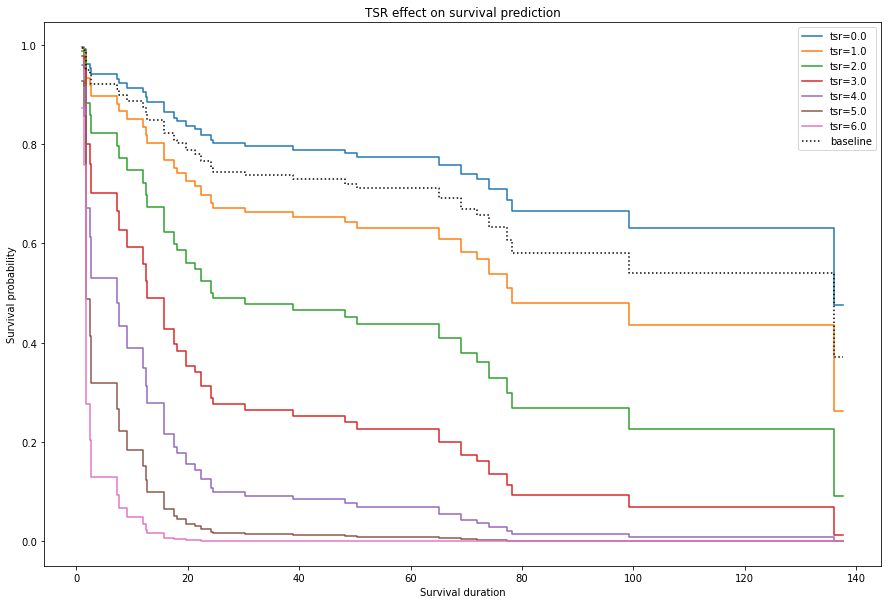

In [98]:
_, ax = plt.subplots(1, 1, figsize=(15,10))
model.plot_partial_effects_on_outcome(['tsr'], np.linspace(0,6,7), ax=ax)
plt.title('TSR effect on survival prediction')
plt.xlabel('Survival duration')
plt.ylabel('Survival probability')
plt.show()

In [49]:
encoders[lbl].transform(encoders[lbl].classes_)

array([0, 1, 2])

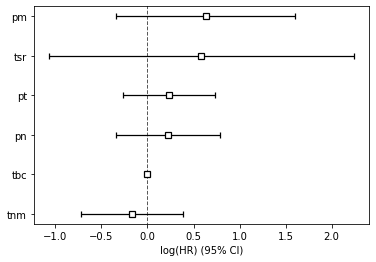

In [99]:
model.plot()
plt.show()

In [82]:
model.check_assumptions(data, p_value_threshold=5e-2)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



C:\Users\Zace VR\anaconda3\envs\fresh\lib\site-packages\lifelines\fitters\mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  for variable in self.params_.index & (columns or self.params_.index):
C:\Users\Zace VR\anaconda3\envs\fresh\lib\site-packages\lifelines\statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 150 total observations, 90 right-censored observations>
         test_name = proportional_hazard_test

---
          test_statistic    p  -log2(p)
pm  km              0.13 0.72      0.47
    rank            0.13 0.72      0.47
pn  km              0.48 0.49      1.03
    rank            0.45 0.50      0.99
pt  km              4.09 0.04      4.54
    rank            4.29 0.04      4.71
tbc km              7.48 0.01      7.32
    rank            6.99 0.01      6.93
tnm km              1.58 0.21      2.26
    rank            1.99 0.16      2.66
tsr km              1.40 0.24      2.08
    rank            1.46 0.23      2.14



1. Variable 'pt' failed the non-proportional test: p-value is 0.0383.

   Advice 1: the functional form of the variable 'pt' might be incorrect. That is, there may be non-
linear terms missing. The proportional hazard test used is very sensitive to incorrect functional
forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'pt' using pd.cut, and then specify it in `strata=['pt', ...]`
in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'tbc' failed the non-proportional test: p-value is 0.0062.

   Advice 1: the functional form of the variable 'tbc' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning 

[]

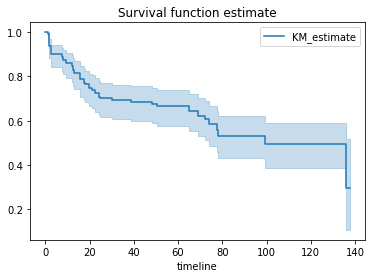

In [87]:
univar_model = KaplanMeierFitter().fit(data['os'], data['os_event'])
univar_model.plot()
plt.title('Survival function estimate')
plt.show()